In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
%matplotlib inline

In [2]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

## Demographics

In [4]:
demographics = pd.read_csv('data_exp_6138-v39_questionnaire-zk38.csv', sep = ",")
#demographics.head(15)
# we asked them 7 questions in total

In [5]:
demographics = demographics[demographics['Question Key'] != 'BEGIN QUESTIONNAIRE']
demographics = demographics[demographics['Question Key'] != 'END QUESTIONNAIRE']
demographics['id'] = demographics['Participant Private ID']
demographics['question'] = demographics['Question Key']
demographics['response'] = demographics['Response']
demographics = demographics[['id', 'question', 'response']]

In [6]:
d = pd.pivot_table(demographics, index = 'id', columns = 'question', values = 'response', aggfunc='first')
d = d.reset_index()
d.columns= ['id','age', 'confirmation_1', 'confirmation_2', 'gender', 'gender_numeric','handedness', 'handedness_numeric', 'degree', 'degree_numeric']


In [7]:
demographics_corr=demographics
demographics_corr['id']=demographics_corr['id'].astype('str')
demographics_corr = demographics_corr.reset_index()
demographics_corr = demographics_corr.drop('index', axis =1).set_index('id')
demographics_corr = demographics_corr.pivot(columns='question',values='response')
demographics_data = demographics_corr[['age-1','gender-1']]
demographics_data['gender'] = np.where(demographics_data['gender-1']=='Male', 0, demographics_data['gender-1'])
demographics_data['gender'] = np.where(demographics_data['gender-1']=='Female', 1, demographics_data['gender-1'])
demographics_data['age'] = demographics_data['age-1']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [8]:
demographics_data = demographics_data[['gender', 'age']]
demographics_data.index

Index(['668220.0', '668225.0', '668237.0', '668239.0', '668240.0', '668244.0',
       '668245.0', '668246.0', '668249.0', '668251.0',
       ...
       '683264.0', '683265.0', '683284.0', '683302.0', '683305.0', '683308.0',
       '683358.0', '684252.0', '684262.0', 'nan'],
      dtype='object', name='id', length=101)

## Questionnaire Data 

In [9]:
def extract_choice(ser):
    choice = []
    for s in ser:
        c = 0
        while c < len(s):
            r = json.loads(s[c])
            for key in r.keys():
                choice.append(r[key])
            c = c + 1
    return choice

### AMI

In [10]:
# import AMI
AMI = pd.read_csv('data_exp_6138-v39_task-j8g3.csv', sep = ",")
#AMI

In [11]:
AMI_group = AMI.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
# response = AMI_group['choice made'][0]
choice = extract_choice(AMI_group['choice made'])
AMI_group = AMI_group.loc[AMI_group.index.repeat(19)] #repeat no of questions times

In [12]:
AMI_group['choice'] = choice
AMI_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]*100

In [13]:
AMI_group.choice[AMI_group.choice == "Completely UNTRUE"] = 4
AMI_group.choice[AMI_group.choice == "Mostly untrue"] = 3
AMI_group.choice[AMI_group.choice == "Neither true nor untrue"] = 2
AMI_group.choice[AMI_group.choice == "Quite true"] = 1
AMI_group.choice[AMI_group.choice == "Completely TRUE"] = 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [14]:
# by taking the mean rating of the items within the subscale.
# bAMI = questions [5 9 10 11 12 16]
# sAMI = questions [2 3 4  8  15 18]
# eAMI = questions [1 6 7  14 17 19]
# trick_question = 13
# tAMI = sum
bAMI = AMI_group[(AMI_group.question_number == 5)|(AMI_group.question_number == 9)|(AMI_group.question_number == 10)|(AMI_group.question_number == 11)|(AMI_group.question_number == 12)|(AMI_group.question_number == 16)]
sAMI = AMI_group[(AMI_group.question_number == 2)|(AMI_group.question_number == 3)|(AMI_group.question_number == 4)|(AMI_group.question_number == 8)|(AMI_group.question_number == 15)|(AMI_group.question_number == 18)]
eAMI = AMI_group[(AMI_group.question_number == 1)|(AMI_group.question_number == 6)|(AMI_group.question_number == 7)|(AMI_group.question_number == 14)|(AMI_group.question_number == 17)|(AMI_group.question_number == 19)]
trick_AMI = AMI_group[(AMI_group.question_number == 13)]
bAMI = bAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
bAMI.columns = ['id', 'bAMI']
bAMI['score'] = bAMI['bAMI']/6
sAMI = sAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
sAMI.columns = ['id', 'sAMI']
sAMI['score'] = sAMI['sAMI']/6
eAMI = eAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
eAMI.columns = ['id', 'eAMI']
eAMI['score'] = eAMI['eAMI']/6
AMI_final = {'id': bAMI['id'], 'bAMI': bAMI['score'], 'sAMI': sAMI['score'], 'eAMI': eAMI['score']}
AMI_final = pd.DataFrame(data=AMI_final)
AMI_final['tAMI'] = (bAMI['score'] + sAMI['score'] + eAMI['score'])/3

### HADS

In [15]:
# import HAD
HADS = pd.read_csv('data_exp_6138-v39_task-w8es.csv', sep = ",")
HADS.drop(HADS.tail(1).index,inplace=True)
HADS = HADS[HADS['Participant Private ID'] != 668245] # twice

In [16]:
HADS_group = HADS.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(HADS_group['choice made'])
HADS_group = HADS_group.loc[HADS_group.index.repeat(15)]

In [17]:
HADS_group['choice'] = choice
HADS_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*99

In [18]:
# question 12 is the trick question
HADS_group['scale'] = [{"Most of the time" : 3, "A lot of the time": 2, "From time to time, occasionally" : 1, "Not at all":0},
                      {"Nearly all the time": 3, "Very often": 2, "Sometimes": 1, "Not at all":0},
                      {"Definitely as much":0, "Not quite so much":1, "Only a little":2, "Hardly at all":3},
                      {"Not at all":0, "Occasionally":1, "Quite Often":2, "Very Often":3},
                      {"Very definitely and quite badly":3, "Yes, but not too badly":2, "A little, but it doesn't worry me":1, "Not at all":0},
                      {"Definitely":3, "I don't take as much care as I should":2,"I may not take quite as much care":1, "I take just as much care as ever":0},
                      {"As much as I always could":0, "Not quite so much now":1, "Definitely not so much now":2, "Not at all":3},
                      {"Very much indeed":3, "Quite a lot":2,"Not very much":1, "Not at all":0},
                      {"A great deal of the time":3, "A lot of the time":2, "From time to time, but not too often":1,"Only occasionally":0},
                      {"As much as I ever did":0, "Rather less than I used to":1, "Definitely less than I used to":2, "Hardly at all":3},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Very often indeed":3, "Quite often":2,"Not very often":1, "Not at all":0},
                      {"Definitely":0, "Usually":1, "Not Often":2,"Not at all":3},
                      {"Often":0, "Sometimes":1,"Not often":2, "Very seldom":3}]*99

In [19]:
# 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,    13, 14, 15
# A, D, D, A, A, D, D, A, A, D,   D,  trick, A,  A, D

# anxiety =  [1, 4, 5, 8, 9, 13, 14]
# depression = [2, 3, 6, 7, 10, 11, 15]

value = []
for index, row in HADS_group.iterrows():
    d = row["scale"]
    k = row['choice']
    value.append(d[k])
HADS_group['value'] = value

depression = HADS_group[(HADS_group.question_number == 2)|(HADS_group.question_number == 3)|(HADS_group.question_number == 6)|(HADS_group.question_number == 7)|(HADS_group.question_number == 10)|(HADS_group.question_number == 11)|(HADS_group.question_number == 15)]
anxiety = HADS_group[(HADS_group.question_number == 1)|(HADS_group.question_number == 4)|(HADS_group.question_number == 5)|(HADS_group.question_number == 8)|(HADS_group.question_number == 9)|(HADS_group.question_number == 13)|(HADS_group.question_number == 14)]
trick = HADS_group[(HADS_group.question_number == 12)]


In [20]:
depression = depression.groupby(['Participant Private ID'])['value'].sum().reset_index()
depression.columns = ['id', 'depression']
anxiety = anxiety.groupby(['Participant Private ID'])['value'].sum().reset_index()
anxiety.columns = ['id', 'anxiety']
#HAD_group.head(5)

In [21]:
HADS_final = {'id': anxiety['id'], 'anxiety': anxiety['anxiety'], 'depression': depression['depression']}
HADS_final = pd.DataFrame(data=HADS_final)
HADS_final['tHAD'] = anxiety['anxiety'] + depression['depression']
HADS_final.loc[-1] = [668245, np.nan, np.nan,  np.nan]


### Baratt 

In [22]:
# import Baratt
barrat = pd.read_csv('data_exp_6138-v39_task-df75.csv', sep = ",")
barrat.drop(barrat.tail(1).index,inplace=True)

In [23]:
barrat_group = barrat.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(barrat_group['choice made'])
barrat_group = barrat_group.loc[barrat_group.index.repeat(31)]

In [24]:
barrat_group['choice'] = choice
barrat_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22, 23, 24, 25, 26, 27, 28, 29, 30, 31]*100

In [25]:
reverse_barrat = barrat_group[barrat_group['question_number'].isin([9, 21,31, 1, 7, 8, 13, 14, 10, 16, 30])]
reverse_barrat.choice[reverse_barrat.choice == "Rarely/Never"] = 4
reverse_barrat.choice[reverse_barrat.choice == "Occasionally"] = 3
reverse_barrat.choice[reverse_barrat.choice == "Often"] = 2
reverse_barrat.choice[reverse_barrat.choice == "Almost always/Always"] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [26]:
# trick question
trick_barrat = barrat_group[barrat_group['question_number']==12]

In [27]:
barrat_group = barrat_group[barrat_group['question_number'].isin([5,11,29, 6, 25, 27, 2, 3, 4, 18, 20, 23, 26, 17, 22, 24,15, 19, 29])]
barrat_group.choice[barrat_group.choice == "Rarely/Never"] = 1
barrat_group.choice[barrat_group.choice == "Occasionally"] = 2
barrat_group.choice[barrat_group.choice == "Often"] = 3
barrat_group.choice[barrat_group.choice == "Almost always/Always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [28]:
barrat_group = pd.concat([barrat_group,reverse_barrat,trick_barrat])

In [29]:
# trick 12

# attentional =  [5, 9*, 11, 21*, 29, 6, 25, 27]
# attention = [5, 9*, 11, 21*, 29]
# Cognitive Instability = [6, 25, 27]
# motor = [2, 3, 4, 18, 20, 23, 26, 17, 22, 24, 31*]
# Motor = [2, 3, 4, 18, 20, 23, 26]
# Perseverance = [17, 22, 24, 31*]
# Nonplanning = [1*, 7*, 8*, 13*, 14*, 15, 10*, 16*, 19, 29, 30*]
# Self-Control = [1*, 7*, 8*, 13*, 14*, 15]
# Cognitive Complexity = [10*, 16*, 19, 28, 30*]
attention = barrat_group[(barrat_group.question_number == 5)|(barrat_group.question_number == 9)|(barrat_group.question_number == 11)|(barrat_group.question_number == 21)|(barrat_group.question_number == 29)]
cognitive_instable = barrat_group[(barrat_group.question_number == 6)|(barrat_group.question_number == 25)|(barrat_group.question_number == 27)]
motor = barrat_group[(barrat_group.question_number == 2)|(barrat_group.question_number == 3)|(barrat_group.question_number == 4)|(barrat_group.question_number == 18)|
                     (barrat_group.question_number == 20)|(barrat_group.question_number == 23)|(barrat_group.question_number == 26)]
perseverance = barrat_group[(barrat_group.question_number == 17)|(barrat_group .question_number == 22)|(barrat_group.question_number == 24)|(barrat_group.question_number == 31)]
self_control = barrat_group[(barrat_group.question_number == 1)|(barrat_group.question_number == 7)|(barrat_group.question_number == 8)|(barrat_group.question_number == 13)|(barrat_group.question_number == 14)|(barrat_group.question_number == 15)]
cognitive_complexity = barrat_group[(barrat_group.question_number == 10)|(barrat_group.question_number == 16)|(barrat_group.question_number == 19)|(barrat_group.question_number == 28)|(barrat_group.question_number == 30)]
trick = barrat_group[barrat_group.question_number == 12]



In [30]:
attention = attention.groupby(['Participant Private ID'])['choice'].sum().reset_index()
attention.columns = ['id', 'attention']
cognitive_instable = cognitive_instable.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_instable.columns = ['id', 'cognitive_instable']
motor = motor.groupby(['Participant Private ID'])['choice'].sum().reset_index()
motor.columns = ['id', 'motor']
perseverance = perseverance.groupby(['Participant Private ID'])['choice'].sum().reset_index()
perseverance.columns = ['id', 'perseverance']
self_control = self_control.groupby(['Participant Private ID'])['choice'].sum().reset_index()
self_control.columns = ['id', 'self_control']
cognitive_complexity = cognitive_complexity.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_complexity.columns = ['id', 'cognitive_complexity']

In [31]:
barrat_final = {'id': attention['id'], 'attention': attention['attention'], 
                'cognitive_instable': cognitive_instable['cognitive_instable'],
               'motor': motor['motor'],
               'perseverance': perseverance['perseverance'],
               'self_control': self_control['self_control'],
               'cognitive_complexity': cognitive_complexity['cognitive_complexity']}
barrat_final = pd.DataFrame(data=barrat_final)
barrat_final['attentional'] = attention['attention'] + cognitive_instable['cognitive_instable']
barrat_final['motor_0'] = motor['motor'] + perseverance['perseverance']
barrat_final['nonplanning'] = self_control['self_control'] + cognitive_complexity['cognitive_complexity']
barrat_final['total'] = barrat_final['attentional'] + barrat_final['motor_0'] + barrat_final['nonplanning']


### Pleasure

In [32]:
# import pleasure
pleasure = pd.read_csv('data_exp_6138-v39_task-uvof.csv', sep = ",")
pleasure.drop(pleasure.tail(1).index,inplace=True)

In [33]:
pleasure_group = pleasure.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(pleasure_group['choice made'])
pleasure_group = pleasure_group.loc[pleasure_group.index.repeat(15)]

In [34]:
pleasure_group['choice'] = choice
pleasure_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*100

In [35]:
# Definitely Agree (= 1)
# Agree (= 2)
# Disagree (= 3)
# Definitely Disagree (= 4)
pleasure_group.choice[pleasure_group.choice == "Strongly agree"] = 1
pleasure_group.choice[pleasure_group.choice == "Agree"] = 2
pleasure_group.choice[pleasure_group.choice == "Disagree"] = 3
pleasure_group.choice[pleasure_group.choice == "Strongly disagree"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.

In [36]:
trick = pleasure_group[pleasure_group.question_number == 8]
#trick.head(100)

In [37]:
pleasure_final = {'id': pleasure_group['Participant Private ID']}
pleasure_final = pd.DataFrame(data=pleasure_final)
p = pleasure_group.groupby('Participant Private ID')['choice'].sum().reset_index(name = 'total')
pleasure_final['total'] = p['total']
pleasure_final=pleasure_final.drop_duplicates()
len(pleasure_final)

100

### Fatigue

In [38]:
# import fatigue
fatigue = pd.read_csv('data_exp_6138-v39_task-j95b.csv', sep = ",")
fatigue.drop(fatigue.tail(1).index,inplace=True)

In [39]:
fatigue_group = fatigue.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice_fatigue= extract_choice(fatigue_group['choice made'])
fatigue_group = fatigue_group.loc[fatigue_group.index.repeat(22)]

In [40]:
fatigue_group['choice'] = choice_fatigue
fatigue_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22]*100

In [41]:
# 'Never', 'Rarely', 'Sometimes', 'Often', 'Almost always'
#   0         1          2            3           4
fatigue_group.choice[fatigue_group.choice == "Never"] = 0
fatigue_group.choice[fatigue_group.choice == "Rarely"] = 1
fatigue_group.choice[fatigue_group.choice == "Sometimes"] = 2
fatigue_group.choice[fatigue_group.choice == "Often"] = 3
fatigue_group.choice[fatigue_group.choice == "Almost always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [42]:
# trick question 5
# Physical 4, 7, 8, 11, 14, 15, 18, 21, 22
# Cognitive 1, 2, 3, 6, 12, 13, 16, 17, 19, 20
# Psychosocial 9, 10

fatigue_physical = fatigue_group[fatigue_group['question_number'].isin([4, 7, 8, 11, 14, 15, 18, 21, 22])]
fatigue_cognitive = fatigue_group[fatigue_group['question_number'].isin([1, 2, 3, 6, 12, 13, 16, 17, 19, 20])]
fatigue_psychological = fatigue_group[fatigue_group['question_number'].isin([9, 10])]
fatigue_trick = fatigue_group[fatigue_group['question_number'].isin([5])]

In [43]:
physical = fatigue_physical.groupby(['Participant Private ID'])['choice'].sum().reset_index()
physical.columns = ['id', 'physical']
cognitive = fatigue_cognitive.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive.columns = ['id', 'cognitive']
psychological = fatigue_psychological.groupby(['Participant Private ID'])['choice'].sum().reset_index()
psychological.columns = ['id', 'psychological']

In [44]:
fatigue_final = {'id': physical['id'], 'physical': physical['physical'], 
                'cognitive': cognitive['cognitive'],
               'psychological': psychological['psychological']}
fatigue_final = pd.DataFrame(data=fatigue_final)
fatigue_final['total'] = fatigue_final['physical'] + fatigue_final['cognitive'] + fatigue_final['psychological']


## In Lab

In [45]:
# import in-lab data and convert to panda dataframe
mat = sio.loadmat('untransformeddataforRN.mat', squeeze_me=True)
m = mat['untransformed_data']
in_lab = pd.DataFrame(m)
in_lab.columns = ['latency', 'price_displayed', 
             'id', 'price_bin', 'apathy', 'environment_binary']

# Into one giant table

HADS - The higher the score, the more anxious/depressed you are.
<br> AMI - The higher the score, the more apathetic you are.
<br> barrat - The higher the score, the more impulsive you are.
<br> Pleasure - The higher the score, the less pleasure you experience. Thus, higher levels of present state of anhedonia.
<br> Fatigue - higher scores indicate a greater impact of fatigue on a person’s activities.

In [46]:
HADS_final['id']=HADS_final['id'].astype('str')
AMI_final['id']=HADS_final['id'].astype('str')
pleasure_final['id']=HADS_final['id'].astype('str')
fatigue_final['id']=HADS_final['id'].astype('str')
barrat_final['id']=HADS_final['id'].astype('str')

In [47]:
HADS_final = HADS_final.reset_index().set_index('id')
AMI_final = AMI_final.reset_index().set_index('id')
pleasure_final = pleasure_final.reset_index().set_index('id')
fatigue_final = fatigue_final.reset_index().set_index('id')
barrat_final = barrat_final.reset_index().set_index('id')

In [48]:
pleasure_final['pleasure'] = pleasure_final['total']

In [49]:
fatigue_final['total_fatigue'] = fatigue_final['total']

In [50]:
barrat_final['attentional_0'] = barrat_final['attentional']
barrat_final['nonplanning_0'] = barrat_final['nonplanning']
barrat_final['barrat_total'] = barrat_final['total']

In [51]:
HADS_final = HADS_final[['anxiety', 'depression', 'tHAD']]
AMI_final = AMI_final[['bAMI', 'sAMI', 'eAMI', 'tAMI']]
pleasure_final = pleasure_final[['pleasure']]
fatigue_final = fatigue_final[['physical', 'cognitive', 'psychological', 'total_fatigue']]
barrat_final = barrat_final[['attention', 'cognitive_instable', 'motor', 'perseverance', 
                             'self_control', 'cognitive_complexity', 'attentional_0', 'motor_0', 
                             'nonplanning_0', 'barrat_total']]




In [52]:
correlation_table = HADS_final.merge(AMI_final, right_index = True, left_index = True, how = 'right')

In [53]:
correlation_table = correlation_table.merge(pleasure_final, right_index = True, left_index = True, how = 'left')

In [54]:
correlation_table = correlation_table.merge(fatigue_final, right_index = True, left_index = True, how = 'left')

In [55]:
correlation_table= correlation_table.merge(barrat_final, right_index = True, left_index = True, how = 'left')

In [56]:
len(correlation_table)

100

In [75]:
correlation_table.head(2)

,gender,age,anxiety,depression,tHAD,bAMI,sAMI,eAMI,tAMI,pleasure,physical,cognitive,psychological,total_fatigue,attention,cognitive_instable,motor,perseverance,self_control,cognitive_complexity,attentional_0,motor_0,nonplanning_0,barrat_total
id,,,,,,,,,,,,,,,,,,,,,,,,
668220.0,Male,43,0.000,0.000,0.000,0.167,0.667,1.167,0.667,18,0,0,0,0,6,4,16,8,9,8,10,24,17,51
668225.0,Male,31,7.000,5.000,12.000,1.500,2.667,0.667,1.611,30,14,12,5,31,9,5,14,7,14,6,14,21,20,55


In [58]:
correlation_table.reset_index(inplace=True)

In [59]:
correlation_table.set_index('id', inplace = True)

In [60]:
correlation_table = demographics_data.merge(correlation_table, right_index = True, left_index = True, how = 'inner')



In [78]:
correlation_table.reset_index(inplace = True)

In [79]:
correlation_table.to_csv('scale_100.csv', sep = ',', encoding='utf-8')

# Heatmap for Correlation among All Scales

In [62]:
graph = correlation_table.corr()

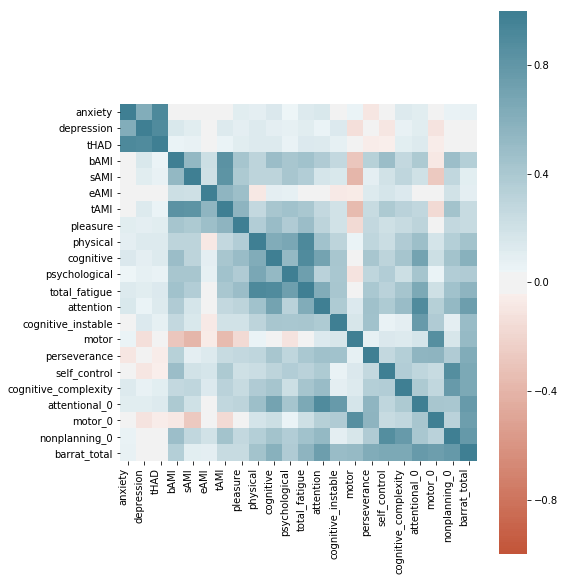

In [63]:
plt.figure(figsize=(8, 10))
ax = sns.heatmap(
    graph, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

HADS - The higher the score, the more anxious/depressed you are.
<br> AMI - The higher the score, the more apathetic you are.
<br> barrat - The higher the score, the more impulsive you are.
<br> Pleasure - The higher the score, the less pleasure you experience. Thus, higher levels of present state of anhedonia.
<br> Fatigue - higher scores indicate a greater impact of fatigue on a person’s activities.

# Heatmap for Apathy, Impulsivity, Depression and Anxiety


In [64]:
AMI_barrat_HADS = correlation_table[['anxiety', 'depression', 'tHAD','bAMI', 'sAMI', 'eAMI', 'tAMI',
                                    'attention', 'cognitive_instable', 'motor', 'perseverance', 
                             'self_control', 'cognitive_complexity', 'attentional_0', 'motor_0', 
                             'nonplanning_0', 'barrat_total']]

In [65]:
graph = AMI_barrat_HADS[['anxiety', 'depression', 'tHAD','bAMI', 'sAMI', 'eAMI', 'tAMI',
                        'attentional_0', 'motor_0', 
                             'nonplanning_0', 'barrat_total']].corr()

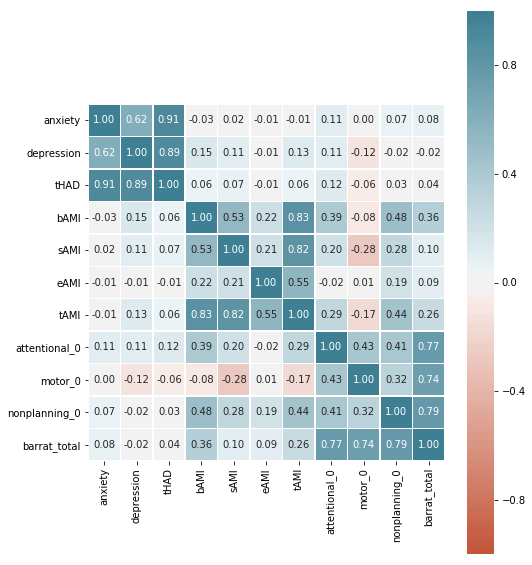

In [66]:
plt.figure(figsize=(8, 10))
ax = sns.heatmap(
    graph, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, linewidths=.5, fmt='.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

In [67]:
graph = AMI_barrat_HADS.corr()

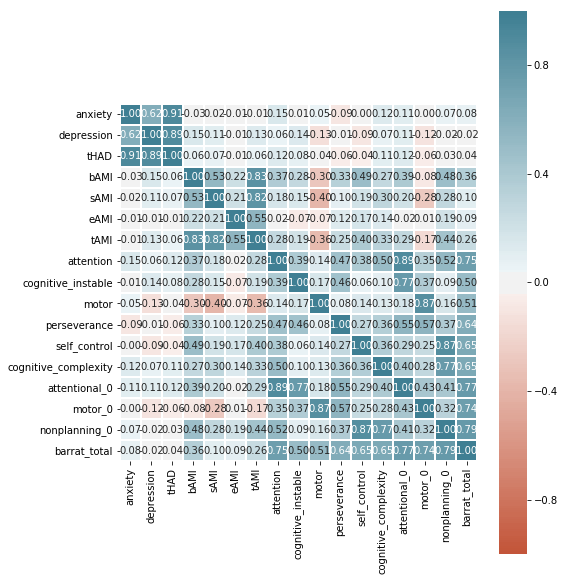

In [68]:
plt.figure(figsize=(8, 10))
ax = sns.heatmap(
    graph, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, linewidths=.5, fmt = '.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

In [69]:
from itertools import product

In [70]:
def compute_corr_and_p(df1, df2):
    corrs = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float64)
    pvals = corrs.copy()
    for i, j in product(df1.columns, df2.columns):
        corrs.loc[i,j], pvals.loc[i,j] = ss.spearmanr(df1[i], df2[j], nan_policy = 'omit')
    return corrs, pvals

def plot(corrs, pvals, siglevel=.01):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask) | (pvals >= siglevel) ] = True
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corrs, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
           cbar_kws={'shrink': .5})

In [71]:
df=AMI_barrat_HADS[['anxiety', 'depression', 'tHAD','bAMI', 'sAMI', 'eAMI', 'tAMI',
                        'attentional_0', 'motor_0', 
                             'nonplanning_0', 'barrat_total']]

In [72]:
corrs, pvals = compute_corr_and_p(df, df)

In [73]:
pvals.to_csv('pvals.csv', sep = ',', encoding='utf-8')

In [74]:
plt.figure(figsize=(8, 10))
mask[np.tril_indices_from(pvals)] = False
ax = sns.heatmap(
    pvals, 
    vmin=0.0000001, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, linewidths=.5, fmt = '.2f', mask = mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

NameError: name 'mask' is not defined

<Figure size 576x720 with 0 Axes>